In [ ]:
# conda install -c conda-forge pdpbox

In [ ]:
#pip install eli5

In [1]:
## load required libraries 
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from pdpbox import pdp, get_dataset, info_plots
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from collections import Counter
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import warnings
import eli5
warnings.filterwarnings('ignore')
init_notebook_mode(connected = True)

df_train = pd.read_csv("Train_trans.csv")

print ("Total Meters: ", df_train.shape[0], "\nTotal Features: ", df_train.shape[1])
df_train.head()

Using TensorFlow backend.


Total Meters:  40500 
Total Features:  52


,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,avg_time_discharging_lag7,...,total_off_time,number_times_restart,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,fail_7
0,5.12,41.11,6.56,25.39,0.086667,-0.006667,4.37,91.70,15.70,39.12,...,49.000000,2.375000,377.080000,367.428750,21.696250,39.005000,4174.875000,14.200000,60.701250,0
1,36.60,5.16,6.23,6.96,0.136667,-1.296667,62.67,6.53,6.16,8.25,...,36.857143,1.000000,350.517857,350.309286,19.883571,32.213571,4161.000000,19.777778,52.097143,0
2,5.51,5.04,4.52,5.96,-0.460000,-0.083333,5.13,5.65,4.14,14.02,...,2.333333,4.095238,346.113333,343.409524,13.675238,20.471429,4152.238095,19.200000,34.146667,0
3,4.66,39.85,35.76,40.69,0.076667,-0.006667,3.93,76.37,60.86,73.53,...,10.789474,0.736842,356.184211,349.844737,16.306842,26.189474,4164.631579,23.625000,42.496316,0
4,5.10,43.24,4.63,5.26,0.040000,-0.153333,4.69,71.44,3.80,6.29,...,14.266667,1.133333,370.904000,367.730000,18.797333,30.812000,4169.800000,12.666667,49.609333,0


In [3]:
X_train = df_train.drop(['fail_7'], axis = 1)
Y_train = df_train['fail_7']

In [4]:
gbdt = GradientBoostingClassifier(random_state = 0).fit(X_train, Y_train)

In [5]:
feature_importances = pd.DataFrame(gbdt.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending = False)

colors = ["gray"] * 6 + ["green"] * 4
trace1 = go.Bar(y = [x.title() + "  " for x in feature_importances.index[:10][::-1]], 
                x = feature_importances.importance[:10][::-1], 
                name = "feature importance (relative)",
                marker = dict(color = colors, opacity = 0.4), orientation = "h")

data = [trace1]

layout = go.Layout(
    margin = dict(l = 400), width = 900,
    xaxis = dict(range = (0.0, 0.4)),
    title = 'Relative Feature Importance',
    barmode = 'group',
    bargap = 0.25
)
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [6]:
df_test = pd.read_csv("Data Challenage/test.csv")

In [7]:
groupb=['avg_time_charging_lag7','charging_rate_lag7','avg_time_discharging_lag7','discharging_rate_lag7',
        'avg_time_charging_lag5','avg_time_discharging_lag5','avg_time_charging_lag6','avg_time_discharging_lag6',
        'avg_time_charging_lag8','avg_time_discharging_lag8','avg_time_charging_lag9','avg_time_discharging_lag9',
        'avg_time_charging_lag10','avg_time_discharging_lag10','avg_time_charging_lag11','avg_time_discharging_lag11',
        'avg_time_charging_lag12','avg_time_discharging_lag12','avg_time_charging_lag13','avg_time_discharging_lag13',
        'avg_time_charging_lag14','avg_time_discharging_lag14','discharging_rate_lag8']
df_test[groupb] = df_test[groupb].fillna(value=df_test[groupb].mean())

In [29]:
X_test = df_test.drop(['deviceid','LastRecord','Date Deployed'], axis = 1)

In [30]:
X_test["charge_cycle_time_below_12"] = X_test["charge_cycle_time_below_12"].astype(int)

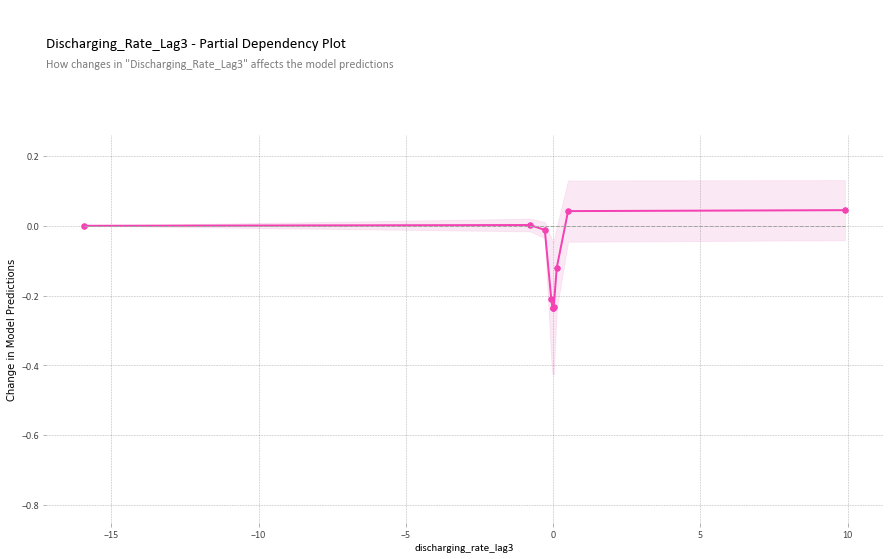

In [35]:
def _plot_pdp(feature, pdp_color, fill_color):
    plot_params = {
        'title': feature.title() + ' - Partial Dependency Plot',
        'title_fontsize': 15,
        'subtitle': 'How changes in "%s" affects the model predictions' % feature.title(),
        'subtitle_fontsize': 12,
        'font_family': 'Calibri',
        'xticks_rotation': 0,
        'line_cmap': 'cool',
        'zero_color': '#a2a5a0',
        'zero_linewidth': 1.0,
        'pdp_linewidth': 2.0,
        'fill_alpha': 0.25,
        'markersize': 5.5,
        'pdp_hl_color': 'green',
        'pdp_color': pdp_color,
        'fill_color': fill_color,

    }
    pdp_goals = pdp.pdp_isolate(model = gbdt, dataset = X_test, model_features = X_test.columns, feature = feature)
    pdp.pdp_plot(pdp_goals, feature, plot_params = plot_params)
    plt.ylabel("Change in Model Predictions");
    plt.show();
    
cols_of_interest = ['discharging_rate_lag3', 'charging_rate_lag3', 'avg_volt_change_charging']

_plot_pdp(cols_of_interest[0], "#f442b3", "#efaad6")

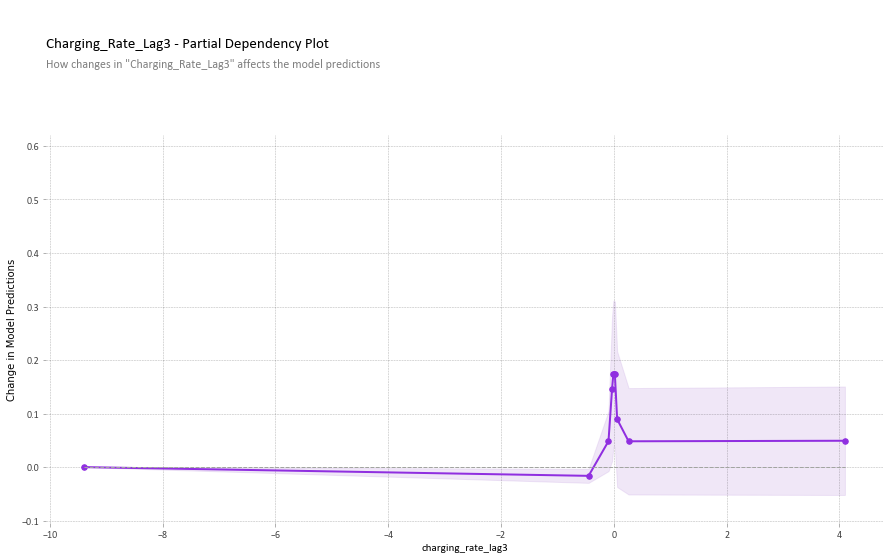

In [36]:
_plot_pdp(cols_of_interest[1], "#902fe0", "#c4a1e0")

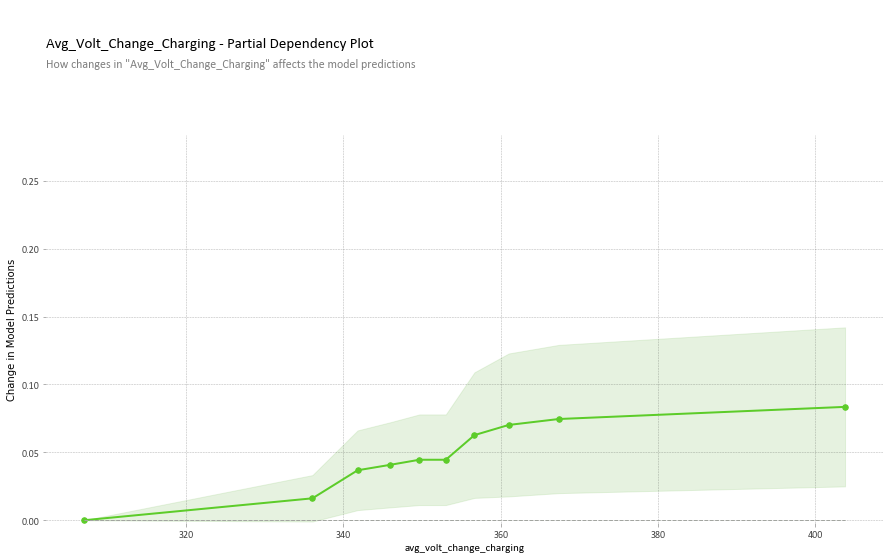

In [37]:
_plot_pdp(cols_of_interest[2], "#5dcc2a", "#9dce86")

In [ ]:
#pip install shap

In [38]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(gbdt)

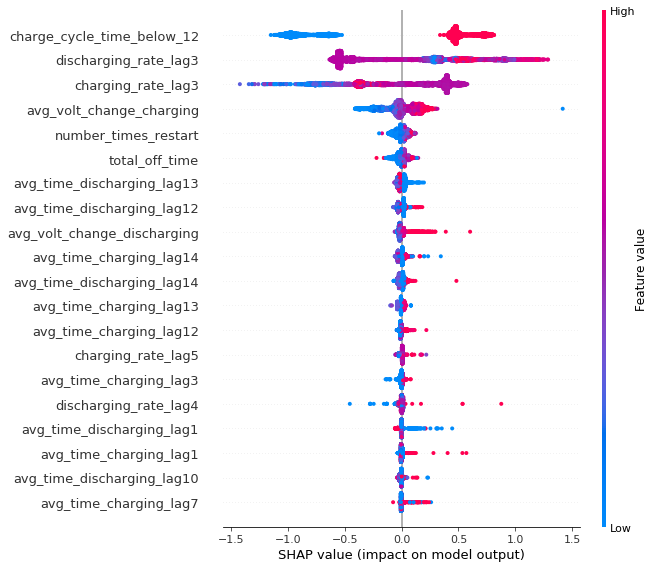

In [39]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [2]:
import seaborn as sns

In [3]:
col_choice = list(df_train.columns)

In [5]:
sorted(col_choice)

['avg_time_charging',
 'avg_time_charging_lag1',
 'avg_time_charging_lag10',
 'avg_time_charging_lag11',
 'avg_time_charging_lag12',
 'avg_time_charging_lag13',
 'avg_time_charging_lag14',
 'avg_time_charging_lag2',
 'avg_time_charging_lag3',
 'avg_time_charging_lag4',
 'avg_time_charging_lag5',
 'avg_time_charging_lag6',
 'avg_time_charging_lag7',
 'avg_time_charging_lag8',
 'avg_time_charging_lag9',
 'avg_time_discharging',
 'avg_time_discharging_lag1',
 'avg_time_discharging_lag10',
 'avg_time_discharging_lag11',
 'avg_time_discharging_lag12',
 'avg_time_discharging_lag13',
 'avg_time_discharging_lag14',
 'avg_time_discharging_lag2',
 'avg_time_discharging_lag3',
 'avg_time_discharging_lag4',
 'avg_time_discharging_lag5',
 'avg_time_discharging_lag6',
 'avg_time_discharging_lag7',
 'avg_time_discharging_lag8',
 'avg_time_discharging_lag9',
 'avg_volt_change_charging',
 'avg_volt_change_discharging',
 'charge_cycle_time_below_12',
 'chargecycles',
 'charging_rate_lag3',
 'charging_ra

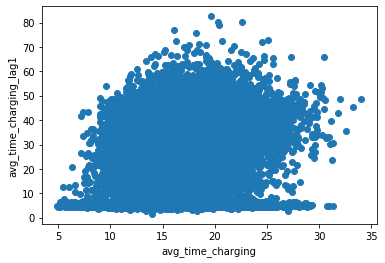

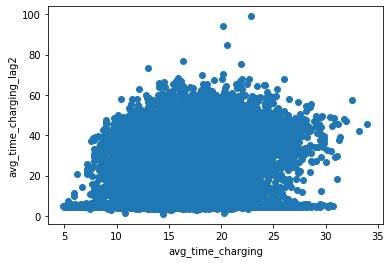

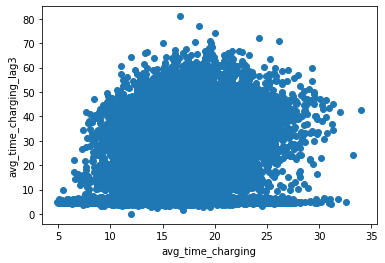

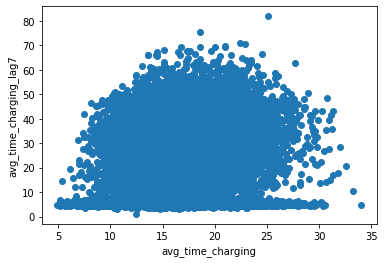

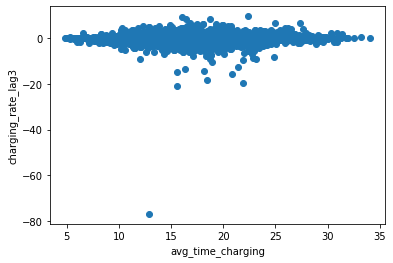

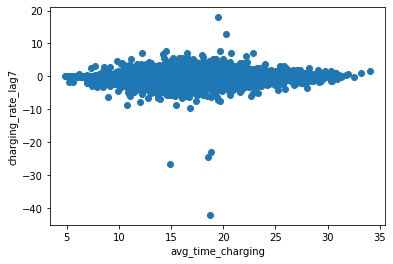

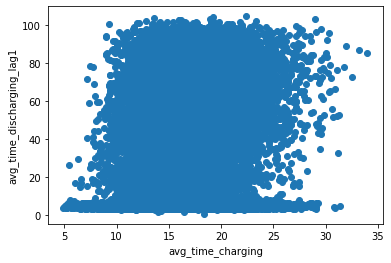

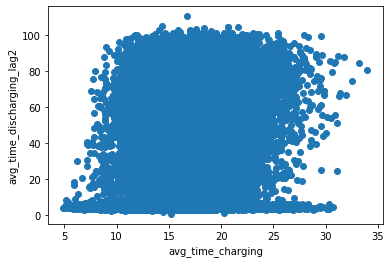

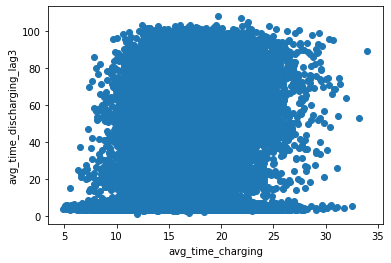

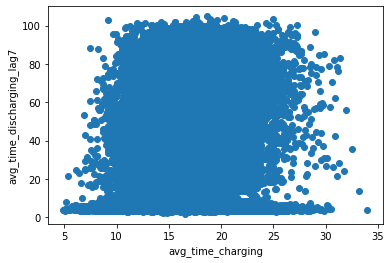

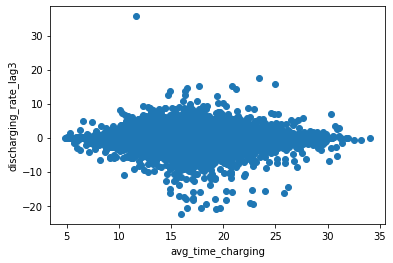

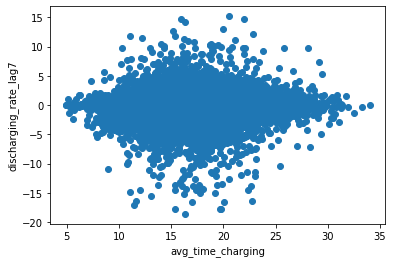

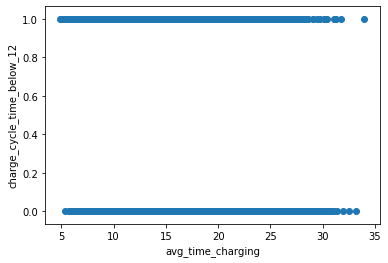

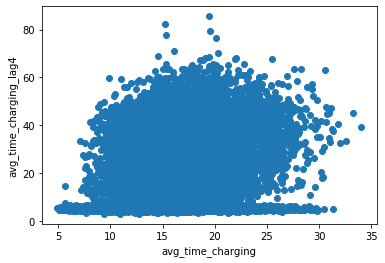

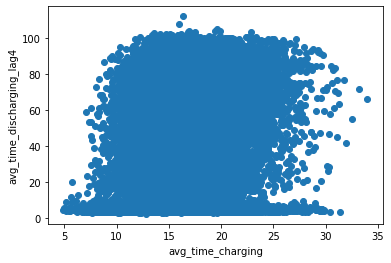

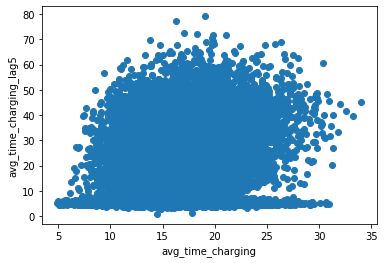

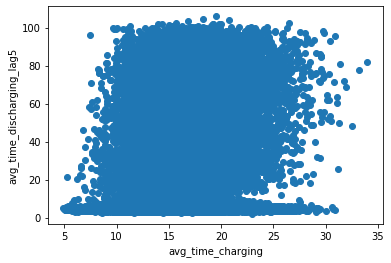

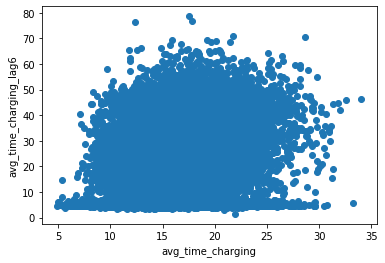

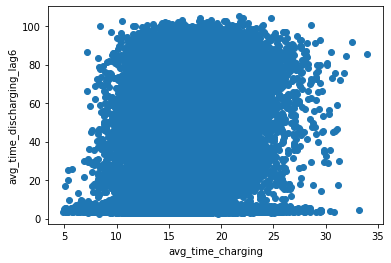

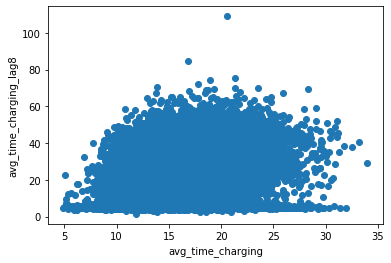

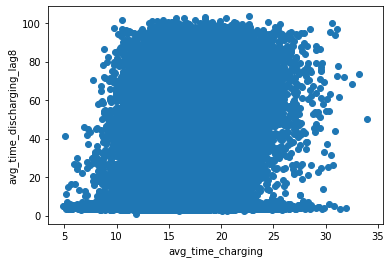

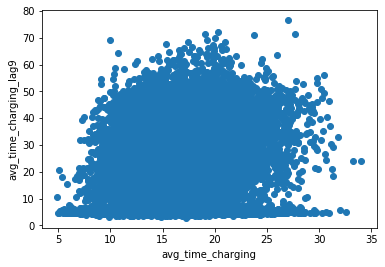

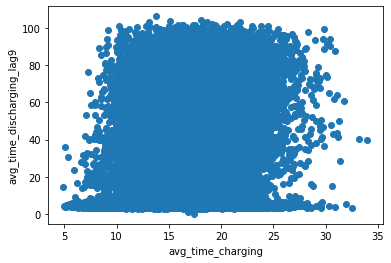

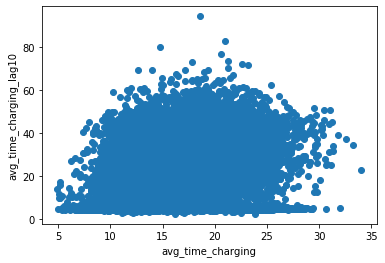

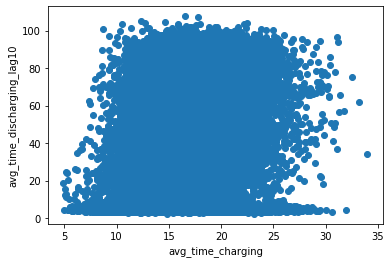

In [ ]:
for i in col_choice:
    plt.scatter(df_train['avg_time_charging'], df_train[i])
    plt.xlabel('avg_time_charging')
    plt.ylabel(i)
    plt.show()

Text(0.5, 1, 'Correlation Matrix Pearson Method')

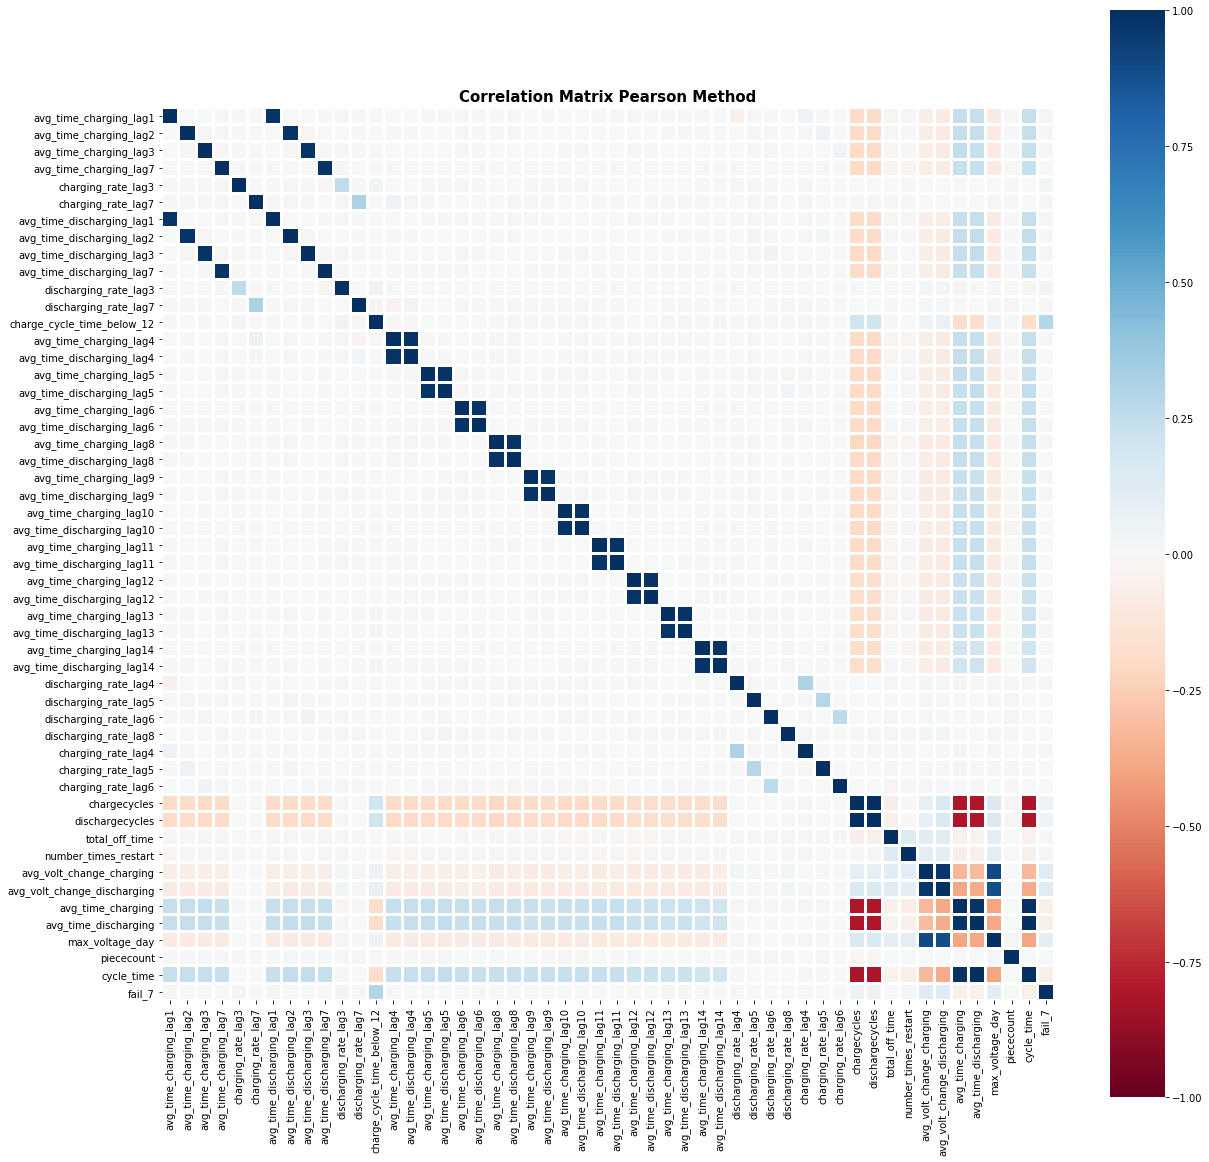

In [19]:
# Pearson Correlation Heatmap
plt.figure(figsize = (20, 20))
sns.heatmap(df_train.corr(method = 'pearson'), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0,
            square = True, linewidths = 2)
plt.title("Correlation Matrix Pearson Method", size = 15, weight = 'bold')